## Import dependencies

In [161]:
import io
import os

import boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.amazon.amazon_estimator import RecordSet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans as SKLearnKMeans

In [24]:
%matplotlib inline

## Load the data
The credit card holder data is saved in a file called `CC GENERAL.csv` in an S3 bucket called `credit-card-behavior-analysis`

In [5]:
s3_client = boto3.client('s3')
data_bucket_name = 'credit-card-behavior-analysis'

[05/28/25 14:03:42] INFO     Found credentials from IAM Role:                                   ]8;id=297348;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=679511;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [7]:
response = s3_client.get_object(Bucket=data_bucket_name, Key='CC GENERAL.csv')

In [8]:
response_body = response['Body'].read()

## Explore the data
Load the data into a Pandas DataFrame object

In [125]:
credit_card_holders_df = pd.read_csv(io.BytesIO(response_body))

In [126]:
credit_card_holders_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### [Following is the Data Dictionary for Credit Card dataset](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data):

* **CUST_ID**: Identification of Credit Card holder (Categorical)
* **BALANCE**: Balance amount left in their account to make purchases (
* **BALANCE_FREQUENCY**: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
* **PURCHASES**: Amount of purchases made from account
* **ONEOFF_PURCHASES**: Maximum purchase amount done in one-go
* **INSTALLMENTS_PURCHASES**: Amount of purchase done in installment
* **CASH_ADVANCE**: Cash in advance given by the user
* **PURCHASES_FREQUENCY**: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
* **ONEOFFPURCHASESFREQUENCY**: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
* **PURCHASESINSTALLMENTSFREQUENCY**: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
* **CASHADVANCEFREQUENCY**: How frequently the cash in advance being paid
* **CASHADVANCETRX**: Number of Transactions made with "Cash in Advanced"
* **PURCHASES_TRX**: Numbe of purchase transactions made
* **CREDIT_LIMIT**: Limit of Credit Card for user
* **PAYMENTS**: Amount of Payment done by user
* **MINIMUM_PAYMENTS**: Minimum amount of payments made by user
* **PRCFULLPAYMENT**: Percent of full payment paid by user
* **TENURE**: Tenure of credit card service for user

In [15]:
credit_card_holders_df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [16]:
credit_card_holders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

_Looks like there are a few rows with missing values in these columns:_
* `CREDIT_LIMIT`
* `MINIMUM_PAYMENTS`

In [130]:
# TODO: Drop missing values? Or fill them?
print(f'There are {len(credit_card_holders_df.dropna())} rows with non-null values.')

There are 8636 rows with non-null values.


## Prepare the training data
Select which columns will be features in the training data. Right now using the columns:
* `BALANCE`
* `PURCHASES`

In [151]:
train_data_df = credit_card_holders_df[['BALANCE', 'PURCHASES']]

<Axes: xlabel='BALANCE', ylabel='PURCHASES'>

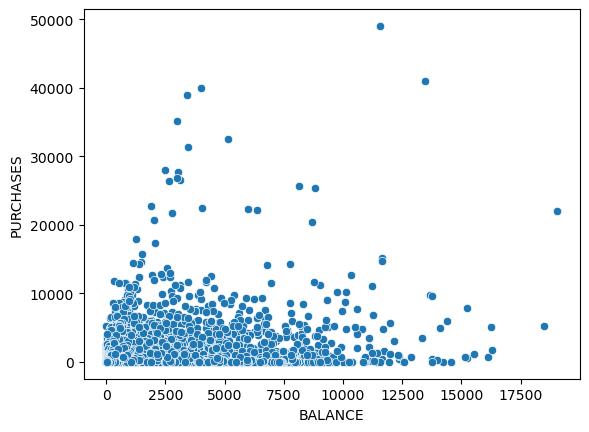

In [152]:
sns.scatterplot(data=train_data_df, x='BALANCE', y='PURCHASES')

In [155]:
train_data_coordinates = list(zip(train_data_df['BALANCE'].values, train_data_df['PURCHASES'].values))

In [156]:
train_data_coordinates[:10]

[(40.900749, 95.4),
 (3202.467416, 0.0),
 (2495.148862, 773.17),
 (1666.670542, 1499.0),
 (817.714335, 16.0),
 (1809.828751, 1333.28),
 (627.260806, 7091.01),
 (1823.652743, 436.2),
 (1014.926473, 861.49),
 (152.225975, 1281.6)]

## Find k
Use the elbow method to determine the number of clusters. Right now using a SciKit-Learn KMeans model to determine the optimal value for `k`.

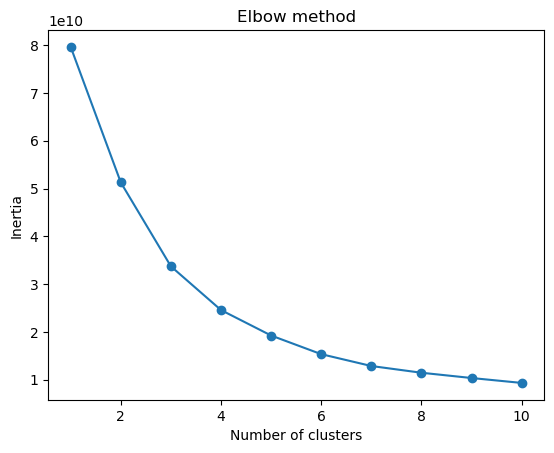

In [157]:
# Reference: https://www.w3schools.com/python/python_ml_k-means.asp

# Inertia is the sum of the squared distances between each data point and the centroid of the cluster.
# The elbow is where the the interia becomes more linear.

inertias = []

for i in range(1,11):
    kmeans = SKLearnKMeans(n_clusters=i)
    kmeans.fit(train_data_coordinates)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Set the optimal number of clusters

In [167]:
optimal_number_of_clusters = 3

In [168]:
sklearn_kmeans_model = SKLearnKMeans(n_clusters=optimal_number_of_clusters)
sklearn_kmeans_model.fit(train_data_coordinates)

KMeans(n_clusters=3)

<Axes: xlabel='BALANCE', ylabel='PURCHASES'>

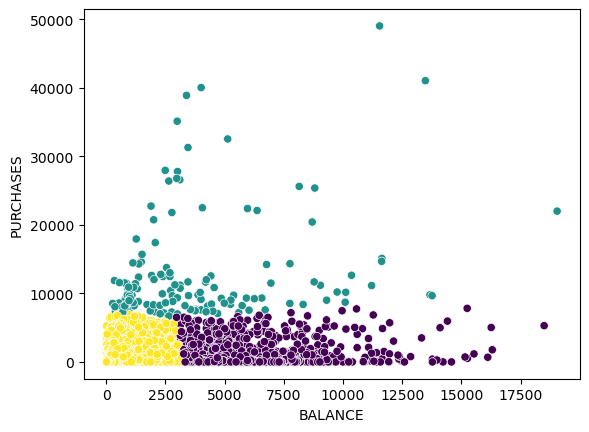

In [169]:
sns.scatterplot(data=train_data_df, x='BALANCE', y='PURCHASES', c=sklearn_kmeans_model.labels_)

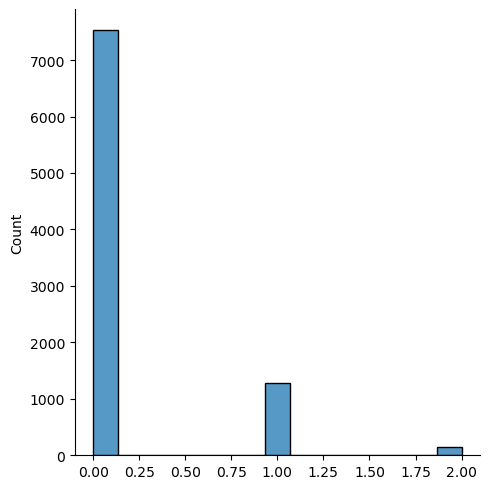

In [160]:
sns.displot(sklearn_kmeans_model.labels_)

## Create the model
Create the SageMaker KMeans model using the `k` value found with the SciKit-Learn KMeans model

Specify the IAM role SageMaker should use for accessing S3 which contains the training data and model artifacts

In [58]:
role = get_execution_role()

Convert the training data to a Numpy array containing 32 bit floats (otherwise the training job will fail)

In [163]:
train_data = train_data_df.values.astype('float32')

In [164]:
type(train_data)

numpy.ndarray

In [170]:
kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f's3://{data_bucket_name}/output',
    k=optimal_number_of_clusters
)

## Train the model
Fit the SageMaker KMeans model with the training data which will create a training job

Convert the training data to a `RecordSet` which is the expected input type for a SageMaker KMeans model

In [171]:
train_data_records = kmeans.record_set(train=train_data)

In [172]:
train_data_records

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-2-607501192754/sagemaker-record-sets/KMeans-2025-05-28-19-27-42-898/.amazon.manifest', 'feature_dim': 2, 'num_records': 8950, 's3_data_type': 'ManifestFile', 'channel': 'train', 'distribution': 'ShardedByS3Key'})

In [84]:
%%time
kmeans.fit(records=train_data_records)

[05/28/25 17:12:30] INFO     Same images used for training and inference. Defaulting to image     ]8;id=180262;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=306041;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=935788;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=826552;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=135383;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=628937;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=878868;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=918591;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-05-28-17-12-30-592        ]8;id=599768;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=847019;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-05-28 17:12:31 Starting - Starting the training job...
2025-05-28 17:13:06 Downloading - Downloading input data...
2025-05-28 17:13:26 Downloading - Downloading the training image.........
2025-05-28 17:14:58 Training - Training image download completed. Training in progress.
2025-05-28 17:14:58 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[05/28/2025 17:14:50 INFO 139828745623360] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_l

## Create a prediction endpoint

In [85]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

[05/28/25 17:16:34] INFO     Same images used for training and inference. Defaulting to image     ]8;id=150467;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=216640;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=763970;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=28631;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating model with name: kmeans-2025-05-28-17-16-34-595               ]8;id=570950;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=920236;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/28/25 17:16:35] INFO     Creating endpoint-config with name kmeans-2025-05-28-17-16-34-595      ]8;id=364441;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=820347;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\

                    INFO     Creating endpoint with name kmeans-2025-05-28-17-16-34-595             ]8;id=26618;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=630315;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

---------!CPU times: user 139 ms, sys: 5.52 ms, total: 145 ms
Wall time: 5min 2s


## Make predictions
Send the training data to the prediction endpoint so that the model can predict which cluster each credit card holder belongs to

In [87]:
%%time
result = kmeans_predictor.predict(train_data)

CPU times: user 257 ms, sys: 12.1 ms, total: 269 ms
Wall time: 1.13 s


## Label data with predictions
Label which cluster each credit card holder is predicted to belong to

In [90]:
result[0]

label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 1043.29749
    }
  }
}
label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0
    }
  }
}

In [91]:
cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

In [92]:
pd.DataFrame(cluster_labels)[0].value_counts()

0.0    7569
2.0    1236
1.0     145
Name: 0, dtype: int64

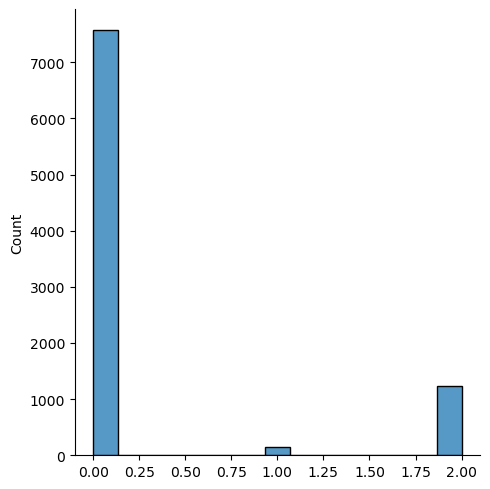

In [95]:
sns.displot(cluster_labels, kde=False)

In [101]:
predictions_df = pd.concat([train_data_df, pd.DataFrame(data=cluster_labels, columns=['Cluster'])], axis=1)

<Axes: xlabel='BALANCE', ylabel='PURCHASES'>

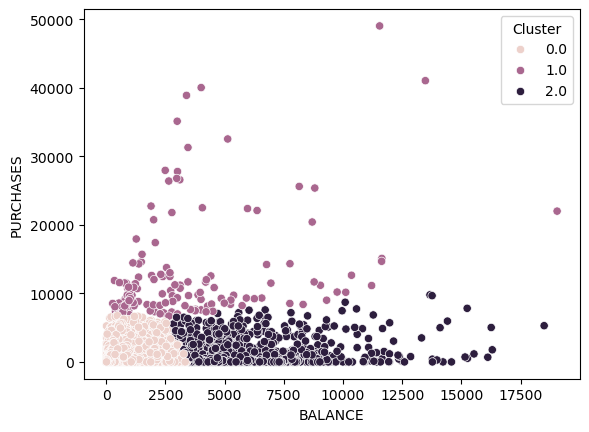

In [119]:
sns.scatterplot(data=predictions_df, x='BALANCE', y='PURCHASES', hue='Cluster')

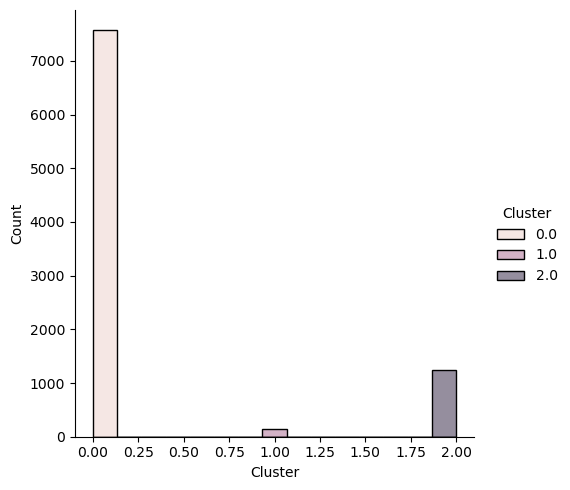

In [118]:
sns.displot(data=predictions_df, x='Cluster', hue='Cluster')

## Interpret the predictions
Try to explain what group of credit card holders each cluster represents

## Delete the prediction endpoint

In [120]:
kmeans_predictor.delete_endpoint()

[05/28/25 18:04:33] INFO     Deleting endpoint configuration with name:                             ]8;id=996056;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=209674;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4995\4995]8;;\
                             kmeans-2025-05-28-17-16-34-595                                                        

                    INFO     Deleting endpoint with name: kmeans-2025-05-28-17-16-34-595            ]8;id=711991;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=52989;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4985\4985]8;;\